In [1]:
from env import host, user, password
import acquire
import prepare
import wrangle

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Acquire

In [3]:
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [4]:
def get_zillow():
    '''
    This function reads in the Zillow data from the Codeup db
    with properties_2017, predictions_2017 and propertylandusetype tables joined
    returns: a pandas DataFrame 
    '''
    
    zp_query = '''
    SELECT calculatedfinishedsquarefeet, bedroomcnt, bathroomcnt, taxvaluedollarcnt, taxamount, yearbuilt, fips, properties_2017.parcelid
    FROM properties_2017
    JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
    JOIN propertylandusetype ON properties_2017.propertylandusetypeid= propertylandusetype.propertylandusetypeid
    WHERE predictions_2017.transactiondate BETWEEN '2017-05-01' AND '2017-08-31' AND properties_2017.propertylandusetypeid IN (31, 46, 47, 260, 261, 262, 263, 264, 265, 268, 273, 274, 275, 276, 279);
    '''
    return pd.read_sql(zp_query, get_connection('zillow'))

In [5]:
df = get_zillow()

# Prepare

In [6]:
df.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips,parcelid
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756


In [7]:
#calculate tax rate
df['tax_rate'] =df['taxamount']/  df['taxvaluedollarcnt']

In [8]:
#rename columns to make more legible
df = df.rename(columns={"calculatedfinishedsquarefeet": "total_sqft", "bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "taxvaluedollarcnt": "value_assessed", "taxamount": "tax_amount", "yearbuilt": "year_built", "fips": "county_code" })

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28418 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28345 non-null  float64
 1   bedrooms        28418 non-null  float64
 2   bathrooms       28418 non-null  float64
 3   value_assessed  28417 non-null  float64
 4   tax_amount      28417 non-null  float64
 5   year_built      28322 non-null  float64
 6   county_code     28418 non-null  float64
 7   parcelid        28418 non-null  int64  
 8   tax_rate        28416 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.0 MB


In [10]:
#28,418 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28418 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28345 non-null  float64
 1   bedrooms        28418 non-null  float64
 2   bathrooms       28418 non-null  float64
 3   value_assessed  28417 non-null  float64
 4   tax_amount      28417 non-null  float64
 5   year_built      28322 non-null  float64
 6   county_code     28418 non-null  float64
 7   parcelid        28418 non-null  int64  
 8   tax_rate        28416 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.0 MB


In [11]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [12]:
#28,392 entries (removed 26 duplicates)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28392 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28321 non-null  float64
 1   bedrooms        28392 non-null  float64
 2   bathrooms       28392 non-null  float64
 3   value_assessed  28391 non-null  float64
 4   tax_amount      28391 non-null  float64
 5   year_built      28298 non-null  float64
 6   county_code     28392 non-null  float64
 7   parcelid        28392 non-null  int64  
 8   tax_rate        28390 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [13]:
# replace nan values
df.replace(r'^\s*$', np.nan, regex=True)

,total_sqft,bedrooms,bathrooms,value_assessed,tax_amount,year_built,county_code,parcelid,tax_rate
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753,0.012809
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917,0.017045
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026,0.015270
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464,0.011153
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756,0.013064
...,...,...,...,...,...,...,...,...,...
28413,2634.0,6.0,2.0,878190.0,12766.88,1921.0,6037.0,11991766,0.014538
28414,1187.0,4.0,1.5,465999.0,5552.68,1959.0,6059.0,14011468,0.011916
28415,3015.0,5.0,3.0,852813.0,11662.88,2002.0,6059.0,14453399,0.013676
28416,2992.0,5.0,3.0,1120000.0,13663.03,1977.0,6037.0,11128688,0.012199


In [14]:
#drop na values (100 na values)
df.dropna()

,total_sqft,bedrooms,bathrooms,value_assessed,tax_amount,year_built,county_code,parcelid,tax_rate
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753,0.012809
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917,0.017045
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026,0.015270
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464,0.011153
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756,0.013064
...,...,...,...,...,...,...,...,...,...
28413,2634.0,6.0,2.0,878190.0,12766.88,1921.0,6037.0,11991766,0.014538
28414,1187.0,4.0,1.5,465999.0,5552.68,1959.0,6059.0,14011468,0.011916
28415,3015.0,5.0,3.0,852813.0,11662.88,2002.0,6059.0,14453399,0.013676
28416,2992.0,5.0,3.0,1120000.0,13663.03,1977.0,6037.0,11128688,0.012199


In [15]:
df.nunique()

total_sqft         4057
bedrooms             13
bathrooms            20
value_assessed    22933
tax_amount        27938
year_built          131
county_code           3
parcelid          28392
tax_rate          28352
dtype: int64

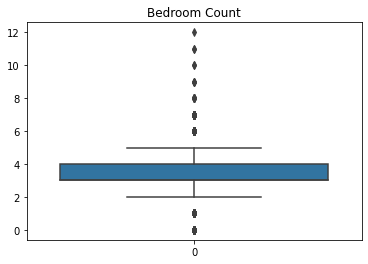

In [16]:
sns.boxplot(data=df.bedrooms)
plt.title('Bedroom Count')
plt.show()

#outliers can be seen here

In [17]:
df.bedrooms.describe()

count    28392.000000
mean         3.297689
std          0.950575
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedrooms, dtype: float64

In [18]:
#finding IQR of bedrooms to find outliers
q1_bed = df['bedrooms'].quantile(0.25)
q3_bed = df['bedrooms'].quantile(0.75)
iqr_bed = q3_bed - q1_bed
iqr_bed, q3_bed, q1_bed

(1.0, 4.0, 3.0)

In [19]:
lowerbound_bed = q1_bed - (1.5 * iqr_bed)
upperbound_bed = q3_bed + (1.5 * iqr_bed)
print(f'Lower bounds for bedroom count is: {lowerbound_bed}')
print(f'Upprt bounds for bedroom count is: {upperbound_bed}')

Lower bounds for bedroom count is: 1.5
Upprt bounds for bedroom count is: 5.5


In [20]:
#remove outliers for bedrooms
df= df[df.bedrooms > lowerbound_bed]
df= df[df.bedrooms < upperbound_bed]

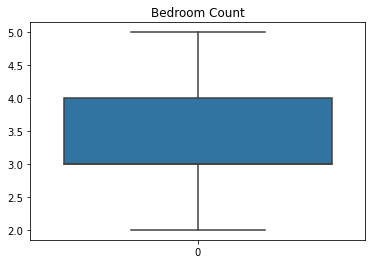

In [21]:
#show outliers have been removed
sns.boxplot(data=df.bedrooms)
plt.title('Bedroom Count')
plt.show()

In [22]:
#descriptive stats for bedrooms, help understand outliers
df.bathrooms.describe()

count    27552.000000
mean         2.299942
std          0.950726
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: bathrooms, dtype: float64

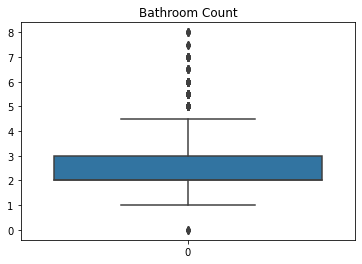

In [23]:
#visualize outliers
sns.boxplot(data=df.bathrooms)
plt.title('Bathroom Count')
plt.show()

In [24]:
#finding IQR of bathrooms to find outliers
q1_bath = df['bathrooms'].quantile(0.25)
q3_bath = df['bathrooms'].quantile(0.75)
iqr_bath = q3_bath - q1_bath

iqr_bath, q3_bath, q1_bath

(1.0, 3.0, 2.0)

In [25]:
lowerbound_bath = q1_bath - (1.5 * iqr_bath)
upperbound_bath = q3_bath + (1.5 * iqr_bath)
lowerbound_bath, upperbound_bath
print(f'Lower bounds for bathroom count is: {lowerbound_bath}')
print(f'Upper bounds for bathroom count is: {upperbound_bath}')

Lower bounds for bathroom count is: 0.5
Upper bounds for bathroom count is: 4.5


In [26]:
#remove outliers for bathroom
df= df[df.bathrooms > lowerbound_bath]
df= df[df.bathrooms < upperbound_bath]

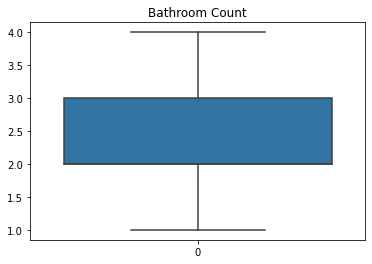

In [27]:
#show outliers have been removed
sns.boxplot(data=df.bathrooms)
plt.title('Bathroom Count')
plt.show()

In [28]:
df.value_assessed.describe()

count    2.649800e+04
mean     4.617563e+05
std      4.627476e+05
min      1.000000e+03
25%      1.922052e+05
50%      3.654890e+05
75%      5.839838e+05
max      1.360010e+07
Name: value_assessed, dtype: float64

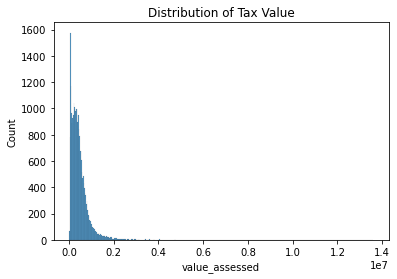

In [29]:
#taxvalue distribution
sns.histplot(data=df.value_assessed)
plt.title('Distribution of Tax Value')
plt.show()

In [30]:
#finding IQR of Tax Value to find outliers
q1_tax = df['value_assessed'].quantile(0.25)
q3_tax = df['value_assessed'].quantile(0.75)
iqr_tax = q3_tax- q1_tax
iqr_tax, q3_tax, q1_tax

(391778.5, 583983.75, 192205.25)

In [31]:
lowerbound_tax = q1_tax - (1.5 * iqr_tax)
upperbound_tax = q3_tax + (1.5 * iqr_tax)
print(f'Lower bounds for Assessed Value is: {lowerbound_tax}')
print(f'Upper bounds for Assessed Value is: {upperbound_tax}')

Lower bounds for Assessed Value is: -395462.5
Upper bounds for Assessed Value is: 1171651.5


In [32]:
#remove outliers for tax
df= df[df.value_assessed > lowerbound_tax]
df= df[df.value_assessed < upperbound_tax]

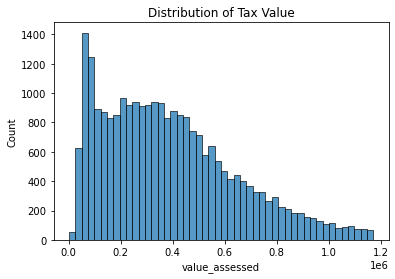

In [33]:
#taxvalue with outliers removed
sns.histplot(data=df.value_assessed)
plt.title('Distribution of Tax Value')
plt.show()

In [34]:
df.total_sqft.describe()

count    25160.000000
mean      1750.539626
std        669.447808
min        326.000000
25%       1253.750000
50%       1600.000000
75%       2119.000000
max       6756.000000
Name: total_sqft, dtype: float64

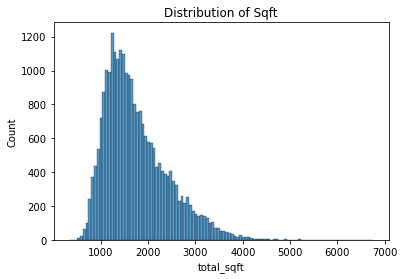

In [35]:
#sqft distribution
sns.histplot(data=df.total_sqft)
plt.title('Distribution of Sqft')
plt.show()

In [36]:
#finding IQR of Tax Value to find outliers
q1_sqft = df['total_sqft'].quantile(0.25)
q3_sqft = df['total_sqft'].quantile(0.75)
iqr_sqft = q3_sqft - q1_sqft
iqr_sqft, q3_sqft, q1_sqft

(865.25, 2119.0, 1253.75)

In [37]:
lowerbound_sqft = q1_sqft - (1.5 * iqr_sqft)
upperbound_sqft = q3_sqft + (1.5 * iqr_sqft)
print(f'Lower bounds for Square Feet  is: {lowerbound_sqft}')
print(f'Upper bounds for Square Feet is: {upperbound_sqft}')

Lower bounds for Square Feet  is: -44.125
Upper bounds for Square Feet is: 3416.875


In [38]:
#remove outliers for sqft
df= df[df.total_sqft > lowerbound_sqft]
df= df[df.total_sqft < upperbound_sqft]

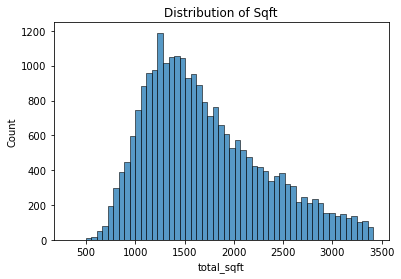

In [39]:
#sqft distribution with outliers removed
sns.histplot(data=df.total_sqft)
plt.title('Distribution of Sqft')
plt.show()

In [40]:
#shape after dropping outliers
df.shape

(24626, 9)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24626 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      24626 non-null  float64
 1   bedrooms        24626 non-null  float64
 2   bathrooms       24626 non-null  float64
 3   value_assessed  24626 non-null  float64
 4   tax_amount      24625 non-null  float64
 5   year_built      24613 non-null  float64
 6   county_code     24626 non-null  float64
 7   parcelid        24626 non-null  int64  
 8   tax_rate        24625 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.9 MB


In [42]:
#split data
train, validate, test = prepare.zillow_split(df)

train -> (13790, 9)
validate -> (5910, 9)
test -> (4926, 9)


# Explore

In [43]:
#take a look at X_train


In [ ]:
#scale data
# - scale only sqft (only continuous variable)
# - assessed value is target

In [ ]:
#now take a look at X_train after being scaled (minmaxscaler)


In [ ]:
y_train.describe()

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
y_train.head()

In [ ]:
#leave tax_rate out of model
#cannot scale categorical variables

In [ ]:
#feature engineering (rfe)
## use on tax_rate 

# create new column - tax value per sqft?
